## 異常檢測
- 經典強大KNN，用於非監督式方法[參考](https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13#:~:text=kNN%20is%20a%20supervised%20ML,systems%2C%20face%20detection%20applications%20etc.)
- 其核心概念其實就是相似性(距離)衡量，大多數的異常檢測也都包含了這個核心概念。

---
2023-01

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors  # 非監督用
from sklearn.datasets import load_iris

In [2]:
data = pd.DataFrame(load_iris()['data'], columns=load_iris()['feature_names'])

## 輸入數據
df = data[["sepal length (cm)", "sepal width (cm)"]]
df.columns = ["sepal_length", "sepal_width"]

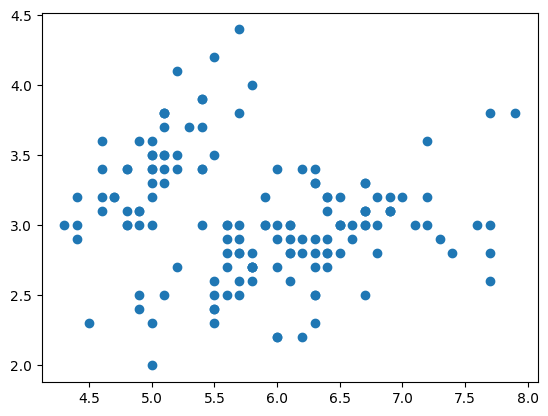

In [3]:
plt.scatter(df["sepal_length"], df["sepal_width"])

In [5]:
## 創建數組
X = df.values

In [12]:
X.shape

(150, 2)

In [6]:
# 實例化模型
nbrs = NearestNeighbors(n_neighbors = 3)
# 擬合模型
nbrs.fit(X)

NearestNeighbors(n_neighbors=3)

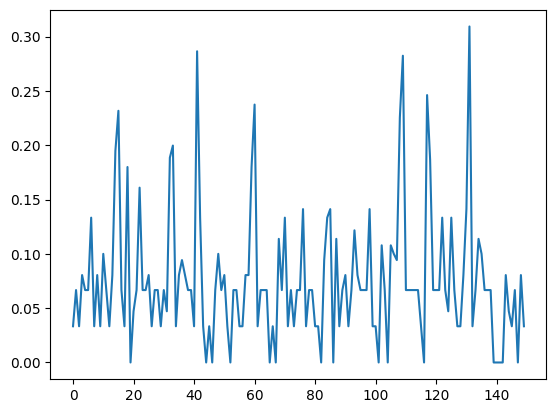

In [7]:
# k-neaighbors 與模型輸出的距離和索引
distances, indexes = nbrs.kneighbors(X)
# 繪製每個觀測值的 k 距離的平均值
plt.plot(distances.mean(axis =1))

> 由上圖可以看到每個點與其他點的平均距離，所以如果值特別大，就代表`該點`非常孤立，可能為異常的值，
> 這個方法非常直覺與好控制，解釋上也非常容易，當然需要去設定 threshold 來判斷，因此需要一些EDA探索。

In [8]:
## 直觀地確定截止值 > 0.15 


threshold = 0.15

outlier_index = np.where(distances.mean(axis = 1) > threshold) 
outlier_index

(array([ 14,  15,  18,  22,  32,  33,  41,  59,  60, 108, 109, 117, 118,
        131], dtype=int64),)

In [9]:
## 過濾異常值
outlier_values = df.iloc[outlier_index] 
outlier_values

,sepal_length,sepal_width
14,5.8,4.0
15,5.7,4.4
18,5.7,3.8
22,4.6,3.6
32,5.2,4.1
33,5.5,4.2
41,4.5,2.3
59,5.2,2.7
60,5.0,2.0
108,6.7,2.5


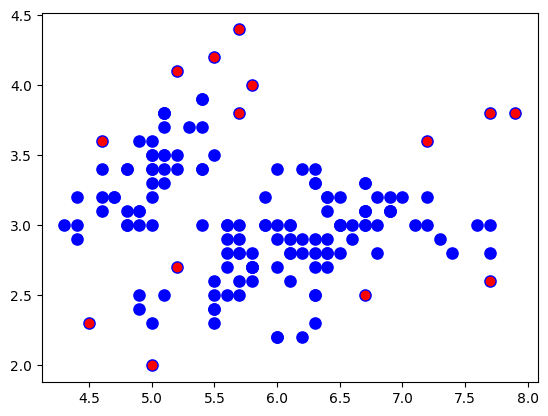

In [10]:
# 繪製數據
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# 繪製異常值
plt.scatter(outlier_values["sepal_length"], outlier_values["sepal_width"], color = "r")

> 可以看到異常值就可以被標示出來，不過需要注意的是視覺化也通常需要降維到2維才有機會。

## Isolation Forest
- 是一個強大的非監督式機器學習模型，如同decision tree一樣，透過隨機選擇特徵以及threshold去分類樣本，只不過，判斷是否為異常是透過，如果那個葉節點(最終但一個樣本)，每次都深度很淺，代表它周圍並沒有類似的樣本，很有可能就是異常值。
- 尤其適合在高維資料中使用。

---
2023-02-03

In [11]:
from sklearn.ensemble import IsolationForest

In [14]:
## 建立模型，可以看到模型就不會有max_depth等參數，因為就是故意要分到每一個樣本都是葉節點！

iso_forest = IsolationForest(n_estimators=100, random_state=222, warm_start=True)
iso_pred = iso_forest.fit_predict(X)
iso_pred

array([ 1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [17]:
## 將異常-1與正常挑出來並透過scatter畫出來看看

normal_index = np.where(iso_pred == 1)
anomaly_index = np.where(iso_pred == -1)

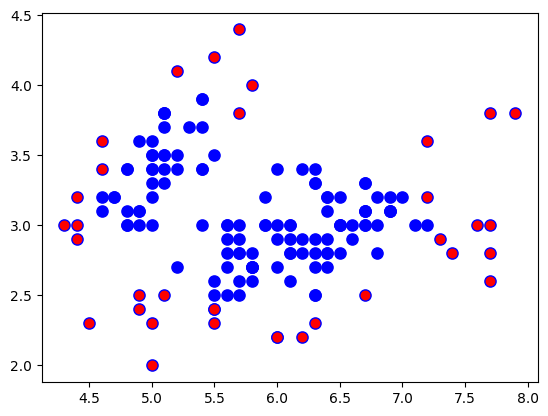

In [20]:
# 繪製全部數據
plt.scatter(df["sepal_length"], df["sepal_width"], color = "b", s = 65)
# 繪製異常值
plt.scatter(df.iloc[anomaly_index]['sepal_length'], df.iloc[anomaly_index]["sepal_width"], color = "r")

> 可以看到因為它的概念關係，在核心區的(中心)會比較難以區分開來，所以深度會較深，會比較是`normal`；而較邊緣的點則因為容易區分，比較容易是`anomaly`